1. Install Dependencies and Setup

In [404]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard
import datetime
import random
random.seed(42)

2. Remove dodgy images

In [405]:
data_dir = 'Data/2_classes_Brain_tumor' 

In [406]:
# image_exts = ['jpeg','jpg', 'bmp', 'png']

In [407]:
# for image_class in os.listdir(data_dir): 
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try: 
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts: 
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e: 
#             print('Issue with image {}'.format(image_path))
#             # os.remove(image_path)

3. Load Data

In [408]:
data = tf.keras.utils.image_dataset_from_directory('Data/2_classes_Brain_tumor')

Found 2999 files belonging to 2 classes.


In [409]:
# tf.keras.preprocessing.image_dataset_from_directory(
#     directory,
#     labels='inferred',
#     label_mode='int',
#     class_names=None,
#     color_mode='rgb',
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation='bilinear',
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     pad_to_aspect_ratio=False,
#     data_format=None,
#     verbose=True
# )

In [410]:
print(len(data))

94


In [411]:
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000002B5570C2D10>)

In [412]:
batch = data_iterator.next()
batch

(array([[[[5.20000000e+01, 5.20000000e+01, 5.20000000e+01],
          [5.10703125e+01, 5.10703125e+01, 5.10703125e+01],
          [5.10000000e+01, 5.10000000e+01, 5.10000000e+01],
          ...,
          [3.31015625e+01, 3.31015625e+01, 3.31015625e+01],
          [3.31015625e+01, 3.31015625e+01, 3.31015625e+01],
          [3.31015625e+01, 3.31015625e+01, 3.31015625e+01]],
 
         [[5.20000000e+01, 5.20000000e+01, 5.20000000e+01],
          [5.10703125e+01, 5.10703125e+01, 5.10703125e+01],
          [5.10000000e+01, 5.10000000e+01, 5.10000000e+01],
          ...,
          [3.40000000e+01, 3.40000000e+01, 3.40000000e+01],
          [3.40000000e+01, 3.40000000e+01, 3.40000000e+01],
          [3.40000000e+01, 3.40000000e+01, 3.40000000e+01]],
 
         [[5.20000000e+01, 5.20000000e+01, 5.20000000e+01],
          [5.10703125e+01, 5.10703125e+01, 5.10703125e+01],
          [5.10000000e+01, 5.10000000e+01, 5.10000000e+01],
          ...,
          [3.34921875e+01, 3.34921875e+01, 3.3492

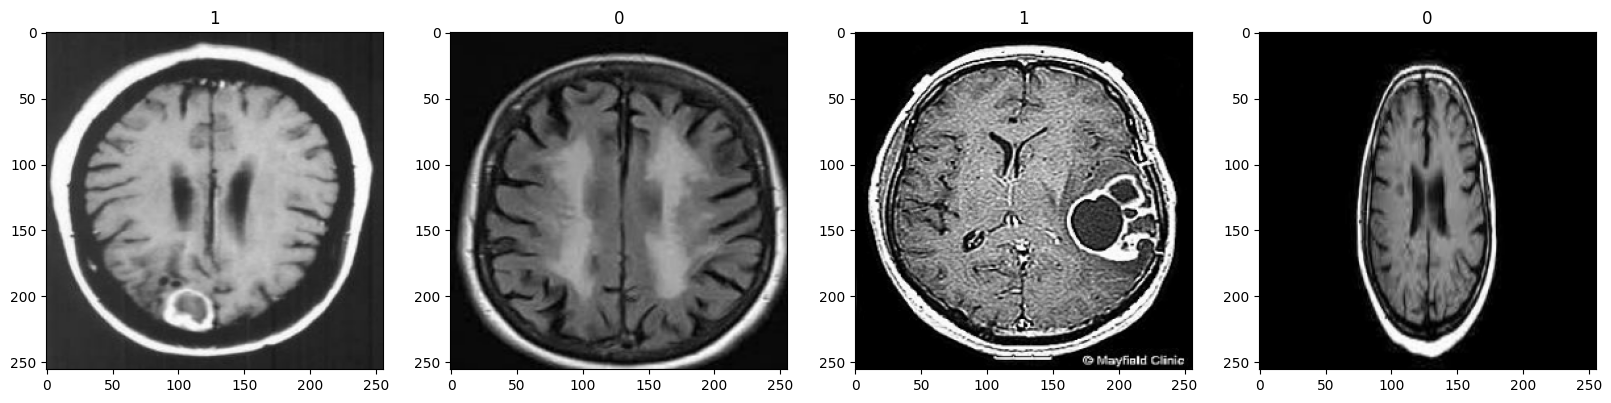

In [413]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [414]:
data = data.map(lambda x,y: (x/255, y))

In [415]:
data.as_numpy_iterator().next()

(array([[[[7.8431377e-03, 7.8431377e-03, 7.8431377e-03],
          [7.8431377e-03, 7.8431377e-03, 7.8431377e-03],
          [7.8431377e-03, 7.8431377e-03, 7.8431377e-03],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
 
         [[7.8431377e-03, 7.8431377e-03, 7.8431377e-03],
          [7.8431377e-03, 7.8431377e-03, 7.8431377e-03],
          [7.8431377e-03, 7.8431377e-03, 7.8431377e-03],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
 
         [[7.8431377e-03, 7.8431377e-03, 7.8431377e-03],
          [7.8431377e-03, 7.8431377e-03, 7.8431377e-03],
          [7.8431377e-03, 7.8431377e-03, 7.8431377e-03],
          ...,
          [3.8296570e-05, 3.8296570e-05, 3.8296570e-05],
          [3.8296570e-05, 3.8296570e-

5. Split Data

In [416]:
dataset = []
labels = []

INPUT_SIZE = (256,256)

label_mapping = {
    'no': 0, 
    'yes': 1
}

for image_class in os.listdir(data_dir): 
    class_index = label_mapping[image_class]
    class_path = os.path.join(data_dir, image_class)
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        if image_path.split('.')[-1] == 'jpg':
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, INPUT_SIZE)
            dataset.append(img)  
            labels.append(class_index)

dataset = np.array(dataset)
labels = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
#test_size = 0.2: 20% của dữ liệu sẽ được chọn ngãu nhiên và sử dụng cho tập kiểm tra, 80% còn lại sẽ được sử dụng cho tập huấn luyện
#random_state = 0: Qúa trình ngẫu nhiên sẽ được khởi tạo với seed 0 -> muốn tái tạo kết quả hoặc so sánh kết quả giữa các phương pháp hoặc mô hình khác nhau.

In [417]:
# Reshape = (n, image_width, image_height, n_channel)
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(2399, 256, 256, 3)
(2399,)
(600, 256, 256, 3)
(600,)


In [418]:
print(y_train)

[1 1 1 ... 0 0 0]


In [419]:
print(y_test)

[0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0
 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1
 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0
 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0
 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0
 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0
 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0
 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0
 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1
 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1
 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0
 1 1 1 1 0 1 1 0 0 0 1 1 

6. Build Deep Learning Model

In [420]:
model = Sequential()

In [421]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [422]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [423]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

7. Train

In [424]:
from keras.utils import to_categorical
from sklearn.preprocessing import normalize

In [425]:
logdir='logs'

In [426]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [427]:

tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)


# Sau đó sử dụng callback trong quá trình fit
hist = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 522ms/step - accuracy: 0.6740 - loss: 20.8055 - val_accuracy: 0.8150 - val_loss: 0.3957
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.8634 - loss: 0.3222 - val_accuracy: 0.9100 - val_loss: 0.2676
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.9665 - loss: 0.1176 - val_accuracy: 0.9417 - val_loss: 0.2020
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9915 - loss: 0.0474 - val_accuracy: 0.9467 - val_loss: 0.2154
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9974 - loss: 0.0213 - val_accuracy: 0.9683 - val_loss: 0.2202
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - accuracy: 0.9978 - loss: 0.0072 - val_accuracy: 0.9617 - val_loss: 0.2277
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9650 - val_loss: 0.2668
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 1.0000 - loss: 8.1133e-04 - val

8. Plot Performance

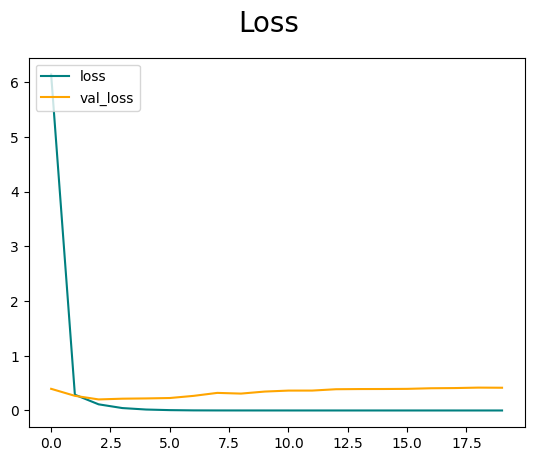

In [428]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

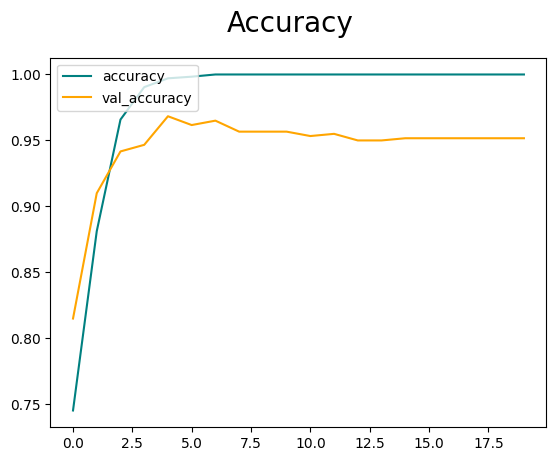

In [429]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

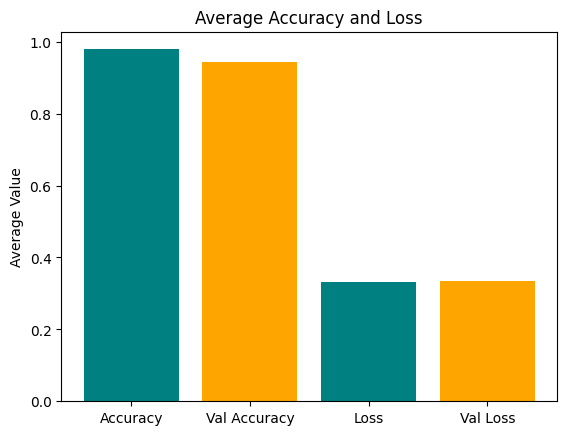

In [430]:
import numpy as np

avg_accuracy = np.mean(hist.history['accuracy'])
avg_val_accuracy = np.mean(hist.history['val_accuracy'])
avg_loss = np.mean(hist.history['loss'])
avg_val_loss = np.mean(hist.history['val_loss'])

fig, ax = plt.subplots()
ax.bar(['Accuracy', 'Val Accuracy', 'Loss', 'Val Loss'], [avg_accuracy, avg_val_accuracy, avg_loss, avg_val_loss], color=['teal', 'orange', 'teal', 'orange'])
ax.set_ylabel('Average Value')
ax.set_title('Average Accuracy and Loss')

plt.show()

In [431]:
avg_accuracy = np.mean(hist.history['accuracy'])
avg_val_accuracy = np.mean(hist.history['val_accuracy'])
avg_loss = np.mean(hist.history['loss'])
avg_val_loss = np.mean(hist.history['val_loss'])

print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Validation Accuracy: {avg_val_accuracy}')
print(f'Average Loss: {avg_loss}')
print(f'Average Validation Loss: {avg_val_loss}')

Average Accuracy: 0.9789078772068024
Average Validation Accuracy: 0.9448333203792572
Average Loss: 0.33056377765033174
Average Validation Loss: 0.3356882184743881


9. Đánh giá mô hình

In [432]:
result=model.predict(x_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [433]:
ket_qua=[]
for i in result:
    if i>0.5: ket_qua.append(1)
    else: ket_qua.append(0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       316
           1       0.95      0.95      0.95       284

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



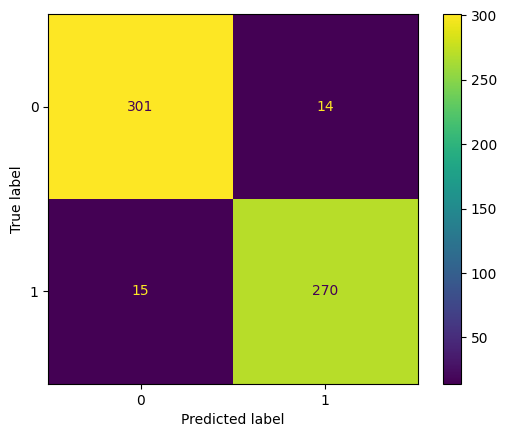

In [434]:
print(classification_report(ket_qua, y_test))
cm=confusion_matrix(y_test, ket_qua)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot(values_format='d')

plt.show()

In [435]:
# Danh sách ket_qua được đưa vào để chuẩn hóa
ket_qua_normalized = []

# Thực hiện chuẩn hóa theo ngưỡng 0.5
for i in ket_qua:
    if i > 0.5:
        ket_qua_normalized.append(1)
    else:
        ket_qua_normalized.append(0)

print(ket_qua_normalized)

[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       316
           1       0.95      0.95      0.95       284

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



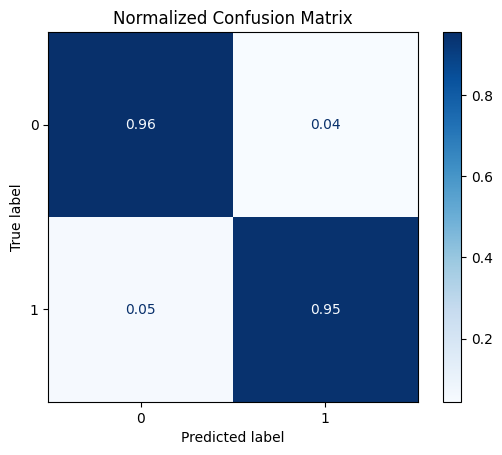

In [436]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Thay thế "ket_qua_normalized" bằng kết quả dự đoán đã được normalized
print(classification_report(ket_qua_normalized, y_test))
cm = confusion_matrix(y_test, ket_qua_normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
cm_display.plot(cmap=plt.cm.Blues, values_format='.2f')

plt.title('Normalized Confusion Matrix')
plt.show()

10. Test

In [437]:
import cv2

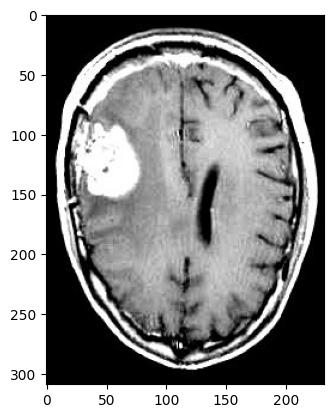

In [439]:
img = cv2.imread('Data/2_classes_Brain_tumor/yes/y2.jpg')
plt.imshow(img)
plt.show()

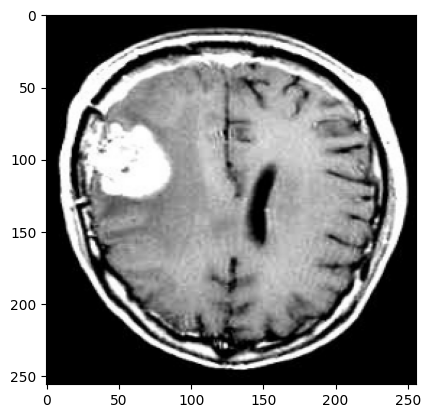

In [440]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [441]:
y_pred = model.predict(np.expand_dims(resize/256, 0))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


array([[0.54601824]], dtype=float32)

In [442]:
if y_pred > 0.5: 
    print(f'yes tumor')
else:
    print(f'no tumor')

yes tumor


11. Save the Model

In [443]:
from tensorflow.keras.models import load_model

In [444]:
model.save(os.path.join('models','imageclassifier.h5'))

In [445]:
new_model = load_model('models/imageclassifier.h5')

In [446]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


array([[0.5462916]], dtype=float32)